# Example usage of gw_eccentricity

Package to measure eccentricity and mean anomaly from a gravitational waveform.    
PAPER: https://arxiv.org/abs/2302.11257 <br>
Throughout this notebook, we refer this paper as PAPER.  
For package details, see https://pypi.org/project/gw_eccentricity.

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import matplotlib.pyplot as plt
import numpy as np
import h5py
from gw_eccentricity import measure_eccentricity
from gw_eccentricity import get_available_methods
from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
use_fancy_plotsettings(usetex=False)

# Read the documentation
The function `measure_eccentricity` can be used to measure eccentricity and mean anomaly for given gravitational waveform data.

In [2]:
help(measure_eccentricity)

Help on function measure_eccentricity in module gw_eccentricity.gw_eccentricity:

measure_eccentricity(tref_in=None, fref_in=None, method='Amplitude', dataDict=None, num_orbits_to_exclude_before_merger=2, precessing=False, frame='inertial', debug_level=0, extra_kwargs=None)
    Measure eccentricity and mean anomaly from a gravitational waveform.
    
    Eccentricity is measured using the GW frequency omega_gw(t) =
    d(phase_gw)/dt. Throughout this documentation, we will refer to phase_gw,
    omega_gw and amp_gw. For nonprecessing systems, these quantities are simply
    the corresponding values of the (2, 2) mode,
    
    amp_gw = amp22, phase_gw = phase22 and omega_gw = omega22.
    
    On the other hand, for precessing systems, we use Eq.(48) and (49) of
    arXiv:1701.00550 to define amp_gw and phase_gw. amp_gw [phase_gw] is
    defined using a symmetric [antisymmetric] combination of
    amplitude [phase] of (2, 2) and (2, -2) mode in the coprecessing frame,
    
    amp_gw =

# Load example data

In this example, we use an eccentric, equal-mass nonspinning binary black hole waveform (SXS:BBH:2305) from the SXS catalog, with the corresponding quasicircular counterpart obtained using the NRHybSur3dq8 model.

**NOTE:** `data/SXS_BBH_2305_22.h5` is a custom-generated file for convenience. To load waveforms using standard formats (e.g the `SXS` catalog format) see `gw_eccentricity.load_waveform` and the notebook `load_waveform_demo.ipynb`.

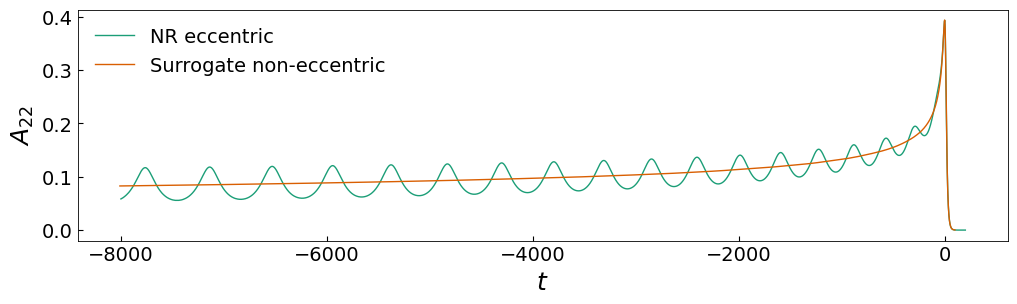

In [4]:
# Load the eccentric NR waveform and the corresponding zero-ecc surrogate waveform
# Look for this file in gw_eccentricity/data.
f = h5py.File(f"data/SXS_BBH_2305_22.h5", "r")
t_ecc_NR, h22_ecc_NR = f["t"][:], f["h22"][:]
t_zeroecc_sur, h22_zeroecc_sur = f["t_zeroecc"][:], f["h22_zeroecc"][:]

# Setup dataDict (Note the required format)
dataDict = {"t": t_ecc_NR,
           "hlm": {(2, 2): h22_ecc_NR},
           "t_zeroecc": t_zeroecc_sur,
           "hlm_zeroecc": {(2, 2): h22_zeroecc_sur}}
f.close()

# Plot the (2,2) mode amplitudes of the two waveforms
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label="NR eccentric")
ax.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label="Surrogate non-eccentric")
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$A_{22}$");

# Usage

## Get the available methods

We have implemented multiple methods to compute eccentricity and mean anomaly. The list of available methods is available through `get_available_methods()`.    
As detailed in the documentation, and Sec.III of the PAPER, the recommended methods are ResidualAmplitude/AmplitudeFits/Amplitude.

In [5]:
get_available_methods()

['Amplitude',
 'Frequency',
 'ResidualAmplitude',
 'ResidualFrequency',
 'AmplitudeFits',
 'FrequencyFits']

## Measure eccentricity/mean_anomaly at reference time
We use the function `measure_eccentricity` to measure the eccentricity and mean anomaly from the waveform data provided in `dataDict`. The reference time `tref_in`, where we measure eccentricity and mean anomaly, can be a single float or an array.

`measure_eccentricity` returns a dictionary that contains the measured values of eccentricity, mean anomaly, the time at which these are measured (`tref_out`) and an object which includes methods for diagnostic plots (see below) and several internal variables.

In [6]:
tref_in = -5500
for method in get_available_methods():
    return_dict = measure_eccentricity(tref_in=tref_in,
                                      method=method,
                                      dataDict=dataDict)
    tref_out = return_dict["tref_out"]
    eccentricity = return_dict["eccentricity"]
    mean_anomaly = return_dict["mean_anomaly"]
    gwecc_object = return_dict["gwecc_object"]
    print(f"method = {method:20s} eccentricity = {eccentricity:.6f}, mean anomaly = {mean_anomaly:.6f}")

method = Amplitude            eccentricity = 0.235859, mean anomaly = 4.915010
method = Frequency            eccentricity = 0.234667, mean anomaly = 4.915923
method = ResidualAmplitude    eccentricity = 0.235284, mean anomaly = 4.919442
method = ResidualFrequency    eccentricity = 0.235561, mean anomaly = 4.921472
method = AmplitudeFits        eccentricity = 0.235264, mean anomaly = 4.918334
method = FrequencyFits        eccentricity = 0.235559, mean anomaly = 4.921232


## Measure eccentricity/mean_anomaly at reference frequency

Eccentricity and mean anomaly can also be measured at a reference frequency (float or array).

Internally, the reference frequency $f_{\mathrm{ref}}$ is used to get the corresponding reference time $t_{\mathrm{ref}}$ by constructing a monotonic **averaged frequency** omega_gw_average($t$) and requiring omega_gw_average$(t_{\mathrm{ref}}) = 2\pi f_{\mathrm{ref}}$. For nonprecessing systems, omega_gw_average defaults to $\langle \omega_{22}\rangle $, the orbit average of $\omega_{22}$. See the documentation and Sec. IID of the PAPER for more details and other options.

**NOTE:** The averaged frequency is automatically computed when `fref_in` is given but **NOT** when `tref_in` is given. However, the averaged frequency can always be computed using `gwecc_object.get_omega_gw_average()` and plotted using `gwecc_object.plot_omega_gw_average()` (see below, under "Making diagnostic plots"). 

**PE NOTE:** When applying `gw_eccentricity` to postprocess the posteriors from an existing parameter estimation run, you can do: 
```python
t_for_omega_gw_avg, omega_gw_avg = gwecc_object.get_omega_gw_average()
fref_min = np.min(omega_gw_avg)/(2*np.pi)
```
at each posterior sample to get the lowest available reference frequency for that sample.  
Then, `max(fref_min)` over all posterior samples tells you what `fref` can be used safely for all posterior samples.     

In [7]:
fref_in = 0.005
for method in get_available_methods():
    return_dict = measure_eccentricity(fref_in=fref_in,
                                      method=method,
                                      dataDict=dataDict)
    fref_out = return_dict["fref_out"]
    eccentricity = return_dict["eccentricity"]
    mean_anomaly = return_dict["mean_anomaly"]
    gwecc_object = return_dict["gwecc_object"]
    print(f"method = {method:20s} eccentricity = {eccentricity:.6f}, mean anomaly = {mean_anomaly:.6f}")

method = Amplitude            eccentricity = 0.210037, mean anomaly = 3.806604
method = Frequency            eccentricity = 0.209659, mean anomaly = 3.800770
method = ResidualAmplitude    eccentricity = 0.209414, mean anomaly = 3.824476
method = ResidualFrequency    eccentricity = 0.209399, mean anomaly = 3.823542
method = AmplitudeFits        eccentricity = 0.209420, mean anomaly = 3.821522
method = FrequencyFits        eccentricity = 0.209416, mean anomaly = 3.811678


# Making diagnostic plots

We also provide methods for making diagnostic plots that can be helpful for investigations. One can simply use `gwecc_object.make_diagnostic_plots()` to make all diagnostic plots, or plot individual data pieces as shown below.

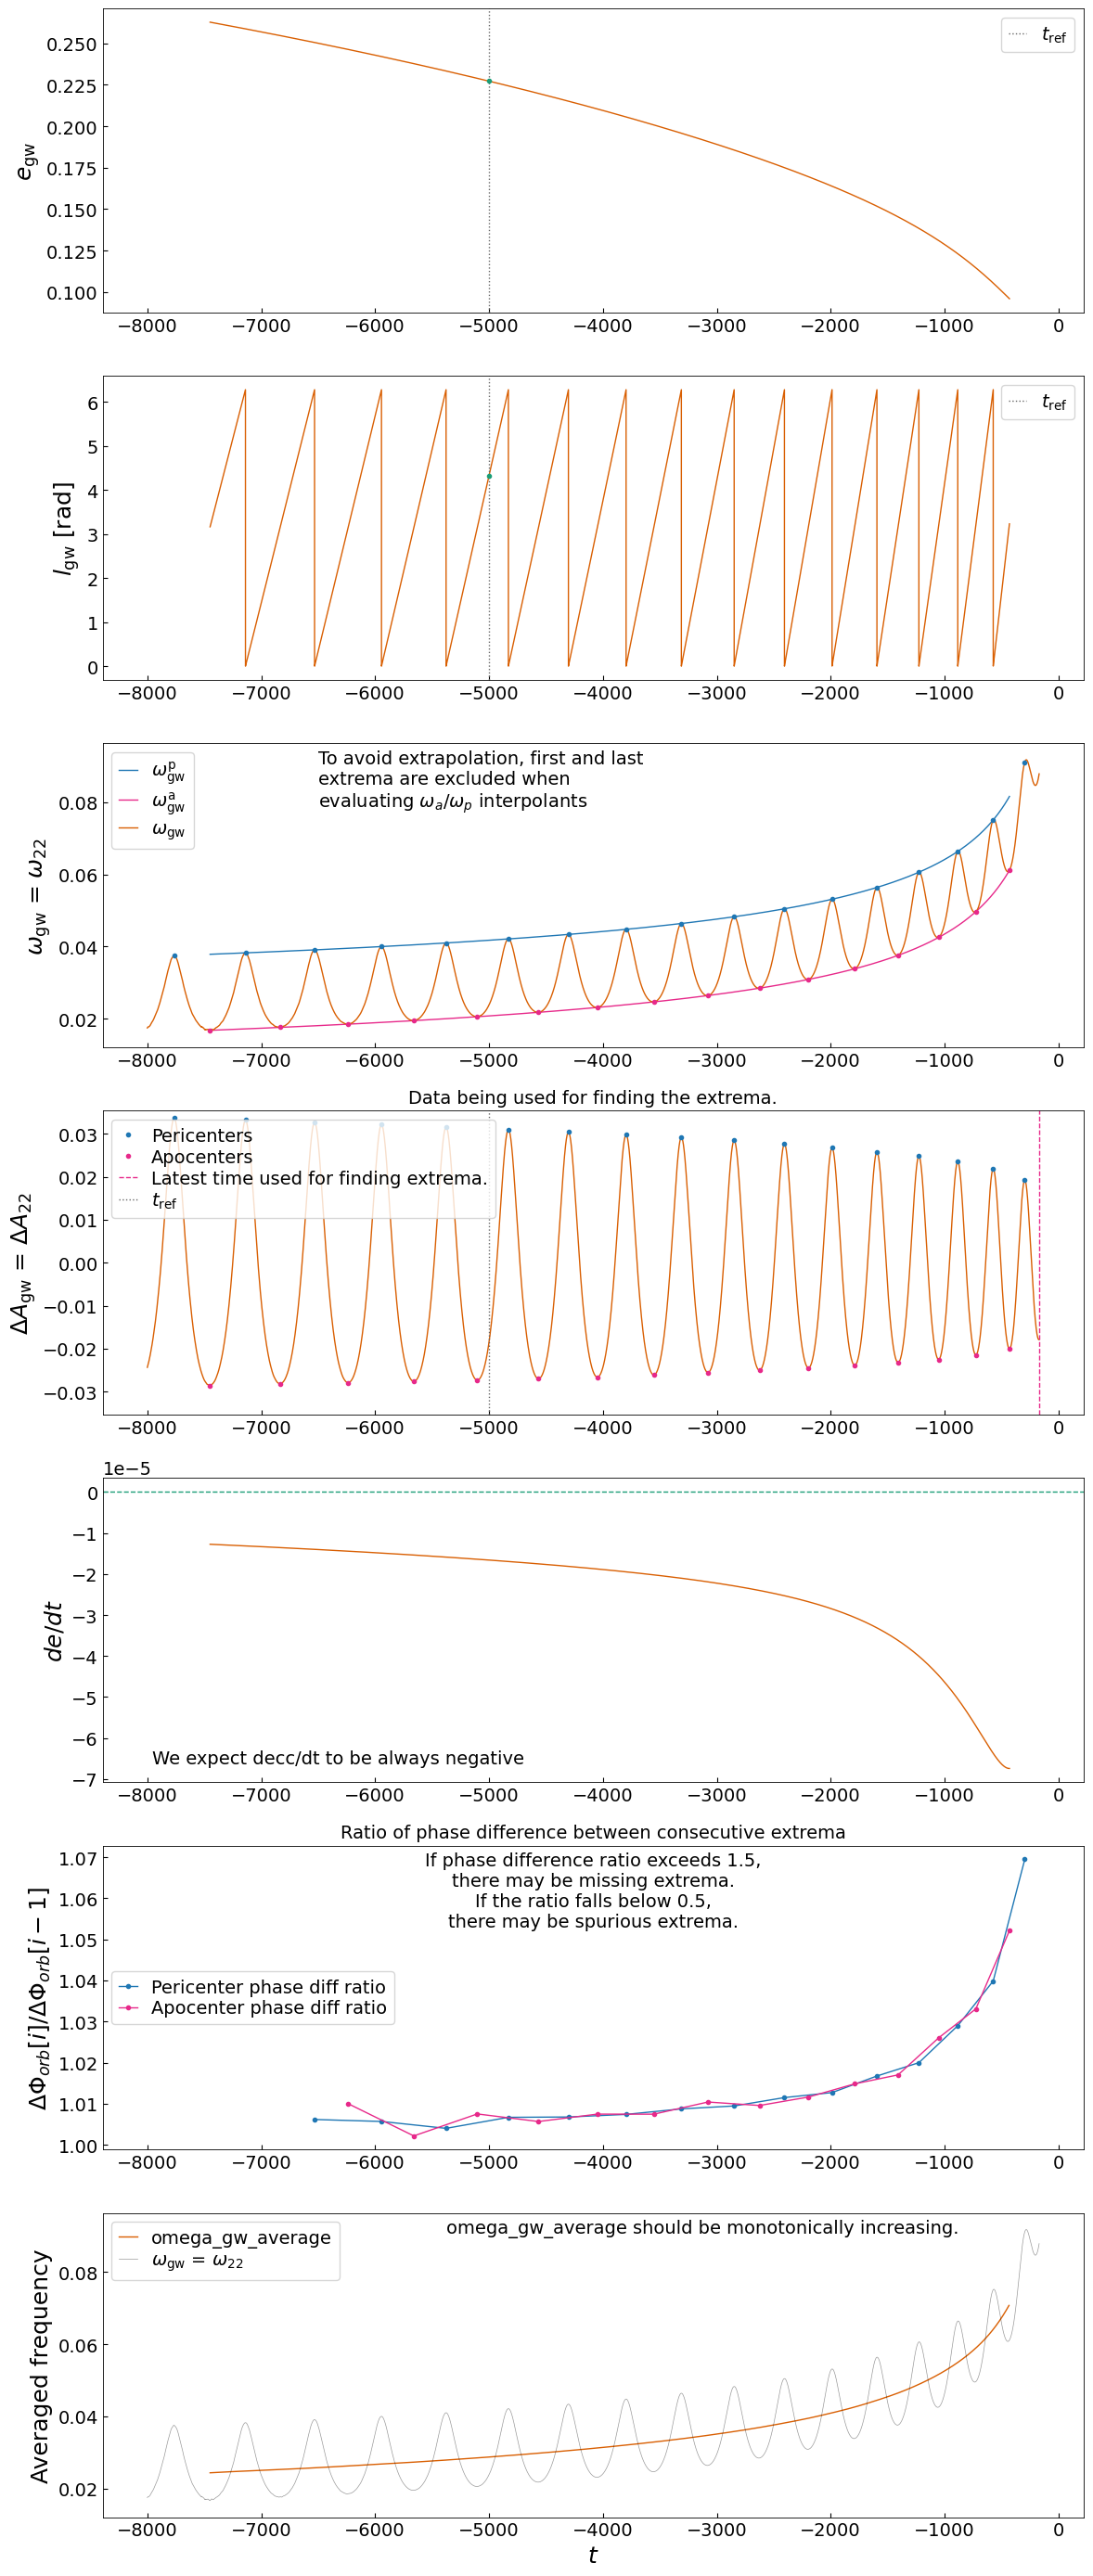

In [8]:
# Let's consider an example using ResidualAmplitude to measure eccentricity at a single time
method = "ResidualAmplitude"
tref_in = -5000
return_dict = measure_eccentricity(tref_in=tref_in,
                                  method=method,
                                  dataDict=dataDict)
gwecc_object = return_dict["gwecc_object"]
fig, ax = gwecc_object.make_diagnostic_plots()

## Let's look at each of these plots separately.

### **Eccentricity vs Time:**
This plot shows the evolution of eccentricity as a function of time.

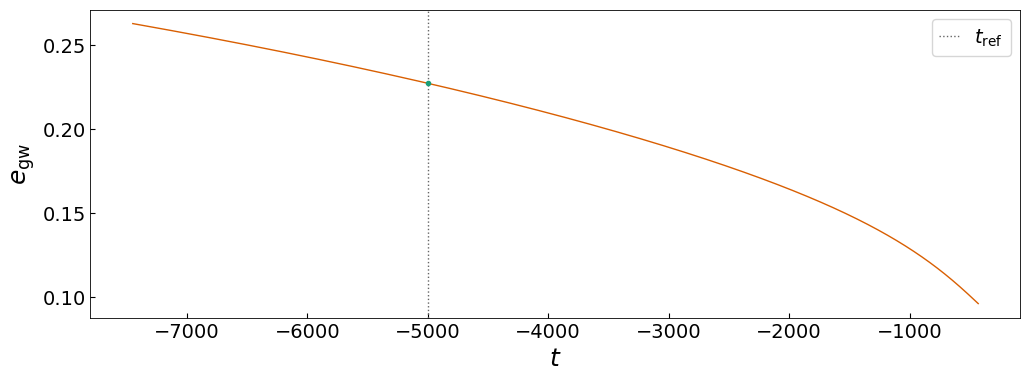

In [9]:
fig, ax = gwecc_object.plot_eccentricity()

### **Mean anomaly vs Time:**
This plot shows the evolution of mean anomaly as a function of time

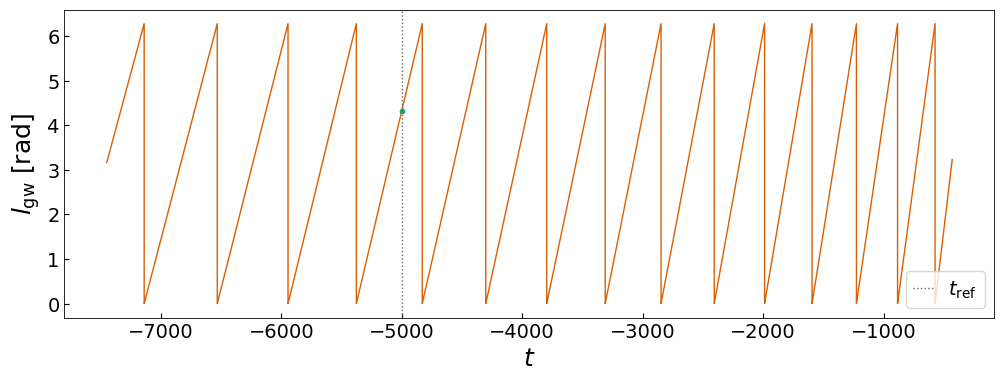

In [10]:
fig, ax = gwecc_object.plot_mean_anomaly()

### **$\omega_{\mathrm{gw}}$ with the locations of apocenters and pericenters:**
This plot shows the $\omega_{\mathrm{gw}} = \omega_{22}(t)$ (because the system is nonprecessing) with the locations of the apocenters and pericenters that are being used for measuring eccentricity indicated by circles.<br>
This would show if the method is missing any local extrema or selecting spuriois extrema.

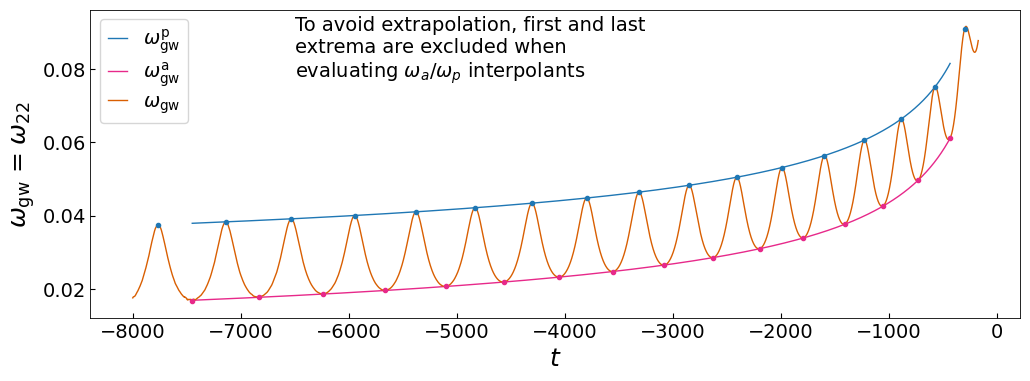

In [11]:
fig, ax = gwecc_object.plot_omega_gw()

### **Data being used to find extrema:**
This plots shows the data that is used to find the locations of the extrema.  
Different methods use different data, see the documentation and Sec.III of the PAPER for more details.

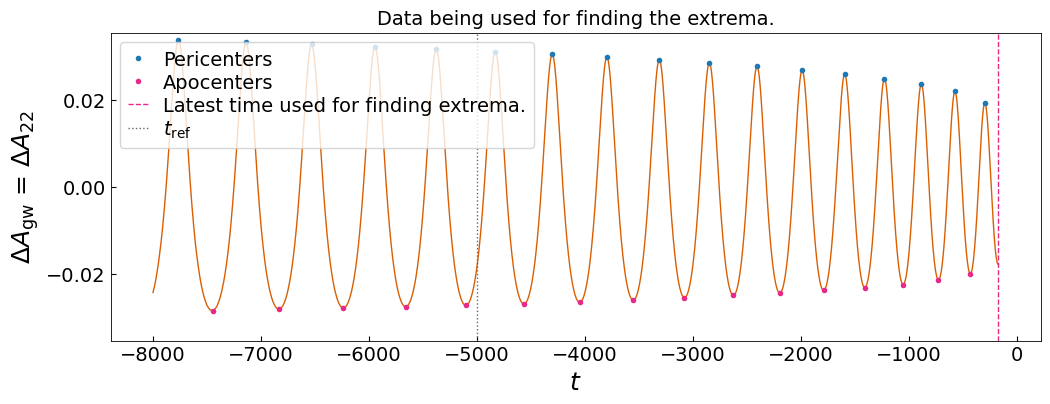

In [12]:
fig, ax = gwecc_object.plot_data_used_for_finding_extrema()

### **$de/dt$ vs Time:**
This plot shows the first derivative of eccentricity as a function of time.  
Eccentricity should be a monotonically decreasing function of time (i.e. $de/dt < 0$).

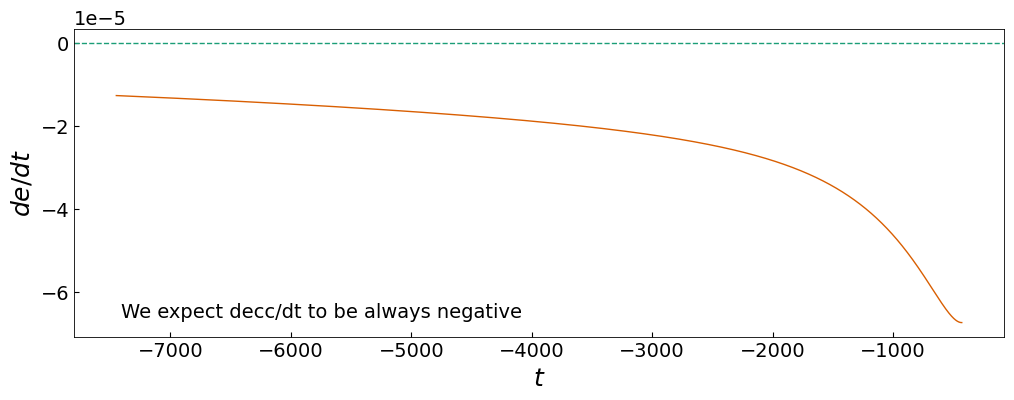

In [13]:
fig, ax = gwecc_object.plot_decc_dt()

### **Ratio of $\Delta \phi_{\mathrm{orb}}$ between consecutive peaks/troughs vs Time:**
$\Delta \phi_{\mathrm{orb}}^{i}/\Delta \phi_{\mathrm{orb}}^{i-1}$, where $\Delta \phi_{\mathrm{orb}}^{i}$
is the change in orbital phase from the previous, i.e., (i-1)-th extrema to the ith extrema. This helps identify missing extrema, as there will be a drastic (roughly factor of 2) change in
$\Delta \phi_{\mathrm{orb}}^{i}$ if there is a missing extrema, and the ratio will go from ~1 to ~2. Similarly, if there is a spurious extrema, the ratio will fall to ~0.5.

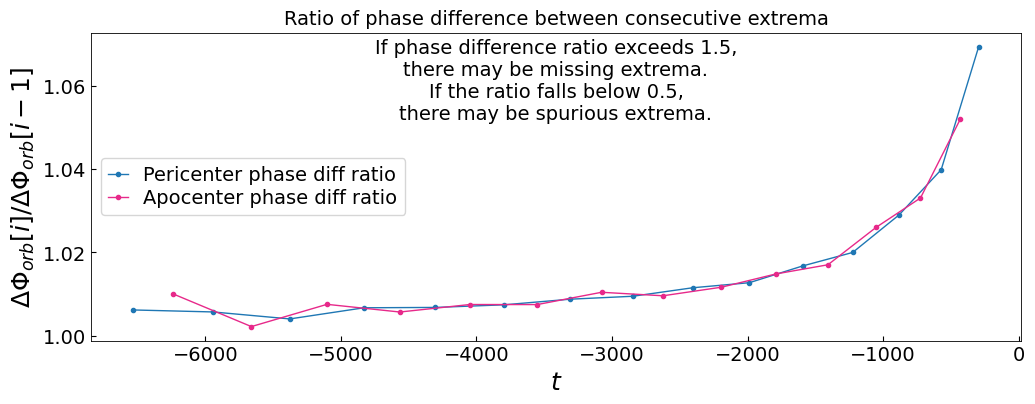

In [14]:
fig, ax = gwecc_object.plot_phase_diff_ratio_between_extrema()

### **Averaged frequency vs Time:**

Because $\omega_{\mathrm{gw}} = \omega_{22}$ is nonmonotonic for eccentric binaries, we use `omega_gw_average` to get the reference time $t_{\mathrm{ref}}$ given a reference
frequency $f_{\mathrm{ref}}$ using `omega_gw_average` $(t_{\mathrm{ref}}) = 2\pi f_{\mathrm{ref}}$. To enable a one-to-one map between $f_{\mathrm{ref}}$ and the $t_{\mathrm{ref}}$, `omega_gw_average` must be a monotonically increasing function of time.

`omega_gw_average` defaults to $\langle \omega_{\mathrm{gw}}\rangle $, the orbit average of $\omega_{\mathrm{gw}} = \langle\omega_{22}\rangle$. See the documentation and Sec. IID of the PAPER for other options.

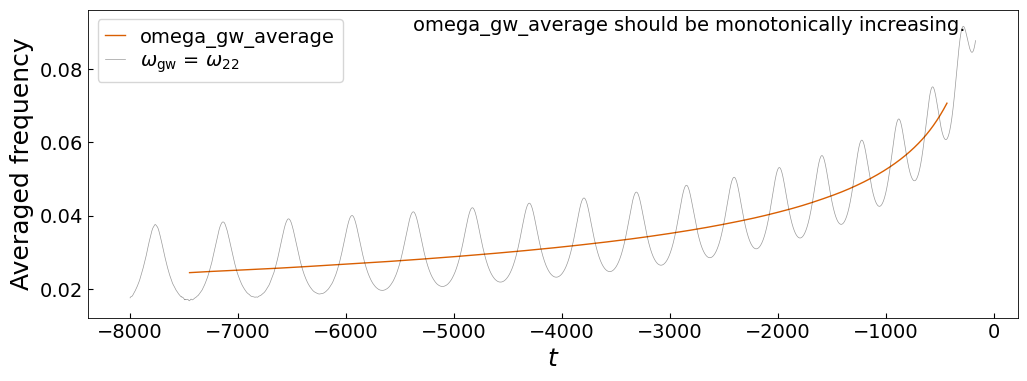

In [15]:
fig, ax = gwecc_object.plot_omega_gw_average()

### **$\Delta A_{\mathrm{gw}}$ vs Time:**
$\Delta A_{\mathrm{gw}}$ is the residual amplitude. In case on non-precessing systems, this is computed from the 22 mode, defined as $\Delta A_{\mathrm{gw}} = A_{\mathrm{22}}(e) - A_{\mathrm{22}}(e=0)$, where we subtract the 22 mode amplitude of the quasicircular waveform (generated using the same set of parameters as the eccentric one, except we set the eccentricity to be zero) from the 22 mode amplitude of the eccentric waveform.

See Sec.IIIB of the PAPER for details.

**NOTE:** This is available only if the provided data dictionary contains quasicircular data.

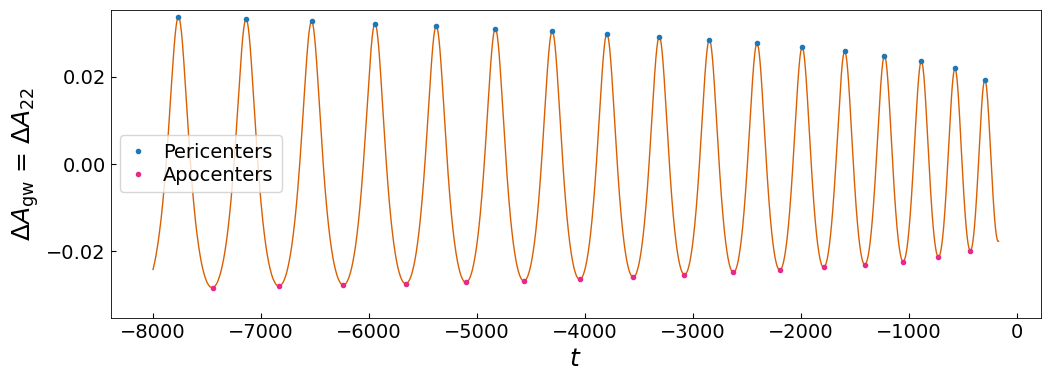

In [16]:
fig, ax = gwecc_object.plot_residual_amp_gw()

### **$\Delta \omega_{\mathrm{gw}}$ vs Time:**
$\Delta \omega_{\mathrm{gw}}$ is the residual omega. In case of non-precessing systems, we compute it using the 22 mode, defined as $\Delta \omega_{\mathrm{gw}} = \omega_{22}(e) - \omega_{22}(e=0)$, where we subtract the 22 mode omega of the quasicircular waveform (generated using the same set of parameters as the eccentric one, except we set the eccentricity to be zero) from the 22 mode omega of the eccentric waveform.

See Sec. IIIB of the PAPER for more details.

**NOTE:** This is available only if the provided data dictionary contains quasicircular data.

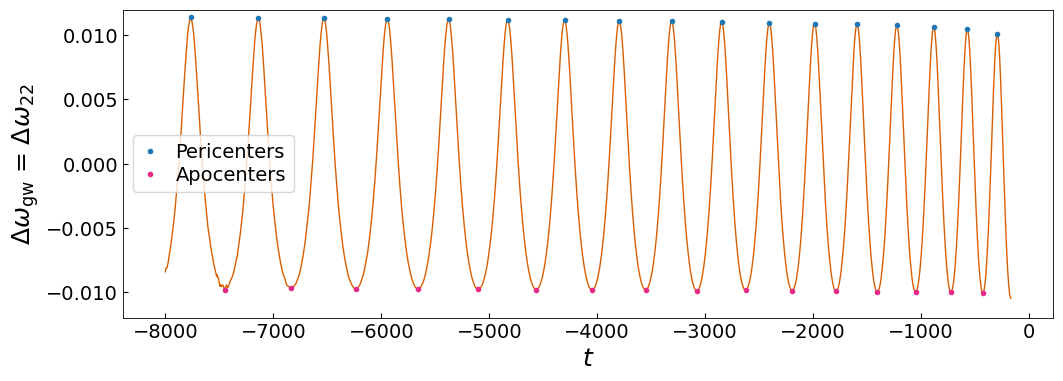

In [17]:
fig, ax = gwecc_object.plot_residual_omega_gw()